In [1]:
!pip install keras==3.*

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 13.5 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.0.5 which is incompatible.


In [3]:
import keras
keras.__version__

'3.0.4'

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
import os
os.chdir("G:\\Мой диск\\SemanticSpray Dataset")
os.getcwd()

'G:\\Мой диск\\SemanticSpray Dataset'

In [5]:
import numpy as np

import tensorflow as tf
from PointNet import get_shape_segmentation_model as pointnet_seg
import keras

import matplotlib.pyplot as plt

In [6]:
os.chdir('C:\\Users\\denet\\OneDrive\\Документы\\Alina\\Поиск работы\\Тестовое ФГУП НАМИ\\DATA')

In [7]:
clouds = []
labels = []
for folder in os.listdir():
    clouds_folder = './'+folder+'/velodyne'
    labels_folder = './'+folder+'/labels'
    clouds_names = os.listdir(clouds_folder)
    for cloud in clouds_names:
        clouds.append(np.fromfile(clouds_folder+'/'+cloud, np.float32).reshape(-1,5))
        labels.append(np.fromfile(labels_folder+'/'+cloud[:-3]+'label', np.int32))

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(clouds, labels)

In [16]:
from collections import Counter

def f(y):
  c = Counter(y)
  return [c[0], c[1], c[2]]

cc = np.array(list(map(f, y_train)))
cc[:, 0] = n - cc[:, 1] + cc[:, 2]

class_weights = {}
for i, j in enumerate(sum(np.mean(cc, axis=0)) / np.mean(cc, axis=0)):
  class_weights[i] = j

class_weights

{0: 1.6356441353175513, 1: 3.221246834819592, 2: 12.790787566435819}

In [15]:
n=500

In [10]:
class DataGenerator(keras.utils.Sequence):

    def __init__(self, data, labels, batch_size=32, shuffle=True, npoints=n, class_weight=None):
        self.data = data
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.data))
        self.npoints = npoints
        self.nclasses = 3
        self.class_weight = class_weight
        self.reminder = len(self.data) % batch_size
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        n = len(self.data) // self.batch_size
        if self.reminder != 0:
           return n+1
        return n

    def __getitem__(self, index):
        if index+1 == self.__len__() and self.reminder != 0:
          indexes = self.indexes[index * self.batch_size:]
        else:
          indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        data = list(map(lambda x: self.cut([self.data[x], self.labels[x]]), indexes))

        if self.class_weight:
          batch_data, batch_labels, batsh_sample_weights = [list(x) for x in zip(*data)]
          return np.array(batch_data), np.array(batch_labels), np.array(batsh_sample_weights)

        batch_data, batch_labels = [list(x) for x in zip(*data)]
        return np.array(batch_data), np.array(batch_labels)

    def cut(self, sample):

        points, labels = sample

        #cut road and background behind of the lidar
        x = points[:, 0].reshape(points.shape[0])
        y = points[:, 1].reshape(points.shape[0])

        condition = (y>-20)&(y<20)&(x>-5)&(x<40)

        points, labels = points[condition], labels[condition]

        #choose npoints number of points from cloud
        index = np.arange(len(points))

        return self.choose_points(points, labels)


    def choose_points(self, points, labels):
      N = len(labels)
      index = np.arange(N)
      new_index = np.array([])
      LABELS = list(set(labels))

      labels_transformed = np.zeros((N, self.nclasses))
      for i in LABELS:
        labels_transformed[labels == i, i] = 1

      if N >= self.npoints:
        for i in LABELS:
          if i != 0:
            new_index = np.append(new_index, index[labels == i])
        N0 = self.npoints - len(new_index)
        new_index = np.append(new_index, np.random.choice(index[labels == 0], N0))
      else:
        p = N / self.npoints
        for i in LABELS:
          j = index[labels == i]
          new_index = np.append(new_index, j)
          new_index = np.append(new_index, np.random.choice(j, int(p * len(j))+1), replace=True)
        new_index = np.random.choice(new_index, self.npoints)

      new_index = new_index.astype(np.int32)

      if self.class_weight:
        sw = self.get_sample_weights(labels[new_index])
        return points[new_index][:, :3], labels_transformed[new_index], sw

      return points[new_index][:, :3], labels_transformed[new_index]


    def get_sample_weights(self, labels):
      return np.array(list(map(lambda y: self.class_weight.get(int(y), 1.0), labels)))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

In [17]:
dg = DataGenerator(X_train, y_train, npoints=n)
dg_val = DataGenerator(X_test, y_test, npoints=n)

In [18]:
validation_batch = next(iter(dg_val))

In [19]:
num_points = n
num_classes = 3

segmentation_model = pointnet_seg(num_points, num_classes)
segmentation_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None, 3)   │       0 │ -                    │
│ (InputLayer)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ input_transformati… │ (None, None, 64)  │     256 │ input_layer[0][0]    │
│ (Conv1D)            │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ input_transformati… │ (None, None, 64)  │     256 │ input_transformatio… │
│ (BatchNormalizatio… │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ input_transformati… │ (None, None, 64)  │       0 │ input_transformatio… │
│ (Activation)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ input_transformati… │ (None, None, 128) │   8,320 │ input_transformatio… │
│ (Conv1D)            │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ input_transformati… │ (None, None, 128) │     512 │ input_transformatio… │
│ (BatchNormalizatio… │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ input_transformati… │ (None, None, 128) │       0 │ input_transformatio… │
│ (Activation)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ input_transformati… │ (None, None,      │ 132,096 │ input_transformatio… │
│ (Conv1D)            │ 1024)             │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ input_transformati… │ (None, None,      │   4,096 │ input_transformatio… │
│ (BatchNormalizatio… │ 1024)             │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ input_transformati… │ (None, None,      │       0 │ input_transformatio… │
│ (Activation)        │ 1024)             │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ global_max_pooling… │ (None, 1024)      │       0 │ input_transformatio… │
│ (GlobalMaxPooling1… │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ input_transformati… │ (None, 512)       │ 524,800 │ global_max_pooling1… │
│ (Dense)             │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ input_transformati… │ (None, 512)       │   2,048 │ input_transformatio… │
│ (BatchNormalizatio… │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ input_transformati… │ (None, 512)       │       0 │ input_transformatio… │
│ (Activation)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ input_transformati… │ (None, 256)       │ 131,328 │ input_transformatio… │
│ (Dense)             │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ input_transformati… │ (None, 256)       │   1,024 │ input_transformatio… │
│ (BatchNormalizatio… │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ input_transformati… │ (None, 256)       │       0 │ input_transformatio

 Total params: 7,369,804 (28.11 MB)

 Trainable params: 7,355,852 (28.06 MB)

 Non-trainable params: 13,952 (54.50 KB)

Steps per epoch: 29.
Total training steps: 290.


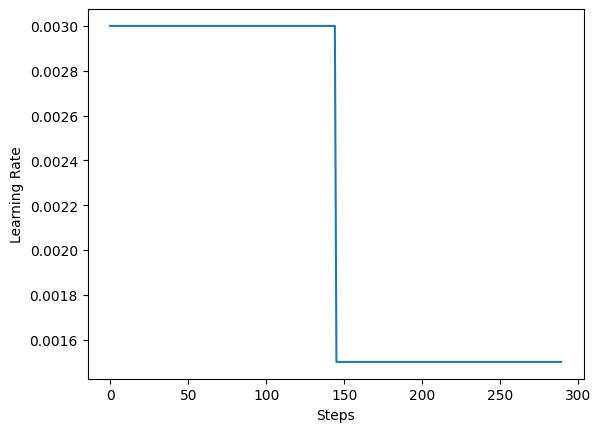

In [21]:
total_training_examples = len(X_train)
BATCH_SIZE = 32
EPOCHS = 10

steps_per_epoch = total_training_examples // BATCH_SIZE
total_training_steps = steps_per_epoch * EPOCHS
print(f"Steps per epoch: {steps_per_epoch}.")
print(f"Total training steps: {total_training_steps}.")

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.003,
    decay_steps=steps_per_epoch * 5,
    decay_rate=0.5,
    staircase=True,
)

steps = range(total_training_steps)
lrs = [lr_schedule(step) for step in steps]

plt.plot(lrs)
plt.xlabel("Steps")
plt.ylabel("Learning Rate")
plt.show()

In [22]:
def run_experiment(epochs):
    segmentation_model = pointnet_seg(num_points, num_classes)
    segmentation_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=["accuracy"],
    )

    checkpoint_filepath = "checkpoint.weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
    )

    history = segmentation_model.fit(
        dg,
        validation_data=dg_val,
        epochs=epochs,
        callbacks=[checkpoint_callback],
    )

    segmentation_model.load_weights(checkpoint_filepath)
    return segmentation_model, history


segmentation_model, history = run_experiment(epochs=EPOCHS)

Epoch 1/10


c:\venv\venv_Alina\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


29/29 ━━━━━━━━━━━━━━━━━━━━ 105s 3s/step - accuracy: 0.5678 - loss: 18625.7285 - val_accuracy: 0.3711 - val_loss: 1578288.6250
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 89s 3s/step - accuracy: 0.7612 - loss: 356.7988 - val_accuracy: 0.6631 - val_loss: 320.4875
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 94s 3s/step - accuracy: 0.8087 - loss: 194.4625 - val_accuracy: 0.7340 - val_loss: 194.2600
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - accuracy: 0.8052 - loss: 159.0048 - val_accuracy: 0.5808 - val_loss: 178.7489
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 105s 4s/step - accuracy: 0.8182 - loss: 153.1967 - val_accuracy: 0.6185 - val_loss: 185.0712
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 103s 4s/step - accuracy: 0.8172 - loss: 146.0802 - val_accuracy: 0.7520 - val_loss: 249.9856
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 101s 3s/step - accuracy: 0.8254 - loss: 145.3712 - val_accuracy: 0.6769 - val_loss: 310.1013
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 107s 4s/step - accuracy: 0.8289 - loss: 142.7974 - va

In [23]:
val_predictions = segmentation_model.predict(validation_batch[0])
print(f"Validation prediction shape: {val_predictions.shape}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Validation prediction shape: (32, 500, 3)


In [16]:
!pip install open3d

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.7/399.7 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 87.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 79.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 82.5 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.6
    Uninstalling widgetsnbextension-3.6.6:
      Successfully uninstalled widgetsnbextension-3.6.6
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


In [24]:
import open3d as o3d

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(validation_batch[0][0])
pcd.colors = o3d.utility.Vector3dVector(validation_batch[1][0])
o3d.visualization.draw_plotly([pcd])

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [25]:
colors = np.zeros(val_predictions.shape)
for clas in range(3):
    colors[:, :, clas] = (np.argmax(val_predictions, axis=-1) == clas).astype(np.int32)
colors.shape

(32, 500, 3)

In [26]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(validation_batch[0][0])
pcd.colors = o3d.utility.Vector3dVector(colors[0])
o3d.visualization.draw_plotly([pcd])

In [27]:
dg = DataGenerator(X_train, y_train, npoints=n, class_weight=class_weights)
dg_val = DataGenerator(X_test, y_test, npoints=n, class_weight=class_weights)

In [28]:
def run_experiment(epochs):
    segmentation_model = pointnet_seg(num_points, num_classes)
    segmentation_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=["accuracy"],
    )

    checkpoint_filepath = "checkpoint_weighted.weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
    )

    history = segmentation_model.fit(
        dg,
        validation_data=dg_val,
        epochs=epochs,
        callbacks=[checkpoint_callback],
    )

    segmentation_model.load_weights(checkpoint_filepath)
    return segmentation_model, history


segmentation_model, history = run_experiment(epochs=EPOCHS)

Epoch 1/10


c:\venv\venv_Alina\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



29/29 ━━━━━━━━━━━━━━━━━━━━ 107s 3s/step - accuracy: 0.4820 - loss: 10438.8789 - val_accuracy: 0.3646 - val_loss: 1663913472.0000
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 87s 3s/step - accuracy: 0.6634 - loss: 371.7751 - val_accuracy: 0.5666 - val_loss: 380139.5000
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 88s 3s/step - accuracy: 0.7640 - loss: 210.0179 - val_accuracy: 0.1097 - val_loss: 1621.7312
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 97s 3s/step - accuracy: 0.8371 - loss: 174.7653 - val_accuracy: 0.7132 - val_loss: 349.0657
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.8530 - loss: 161.8287 - val_accuracy: 0.5492 - val_loss: 312.6625
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - accuracy: 0.8545 - loss: 156.3130 - val_accuracy: 0.5830 - val_loss: 285.1420
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - accuracy: 0.8635 - loss: 153.7223 - val_accuracy: 0.5775 - val_loss: 247.0959
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - accuracy: 0.8777 - loss: 151.9081 -

In [29]:
colors = np.zeros(val_predictions.shape)
for clas in range(3):
    colors[:, :, clas] = (np.argmax(val_predictions, axis=-1) == clas).astype(np.int32)

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(validation_batch[0][0])
pcd.colors = o3d.utility.Vector3dVector(colors[0])
o3d.visualization.draw_plotly([pcd])

In [30]:
omega_out = 1 + sum(np.mean(cc, axis=0)[1:])
omega_in = 1 + np.mean(cc, axis=0)[0]

def energy_loss(y_true, y_pred, omega_in=omega_in, omega_out=omega_out, min_value=0.0, max_value=2.0, l=20e-2):

    # Расчет ошибки сегментации
    seg_loss = tf.keras.losses.CategoricalCrossentropy()(y_true, y_pred)

    #Рассчет энергии
    y_true = tf.cast(tf.argmax(y_true, axis=-1), dtype=tf.float32)
    y_pred = tf.cast(tf.argmax(y_pred, axis=-1), dtype=tf.float32)

    inlier_mask = tf.cast(tf.equal(y_true, 0), dtype=tf.float32)
    outlier_mask = tf.cast(tf.where(tf.logical_or(tf.equal(y_true, 1), tf.equal(y_true, 2)), 1, 0), dtype=tf.float32)

    energy_diff = y_pred - 0
    hinge_in = tf.square(tf.maximum(0.0, energy_diff)) / omega_in

    energy_diff = 2 - y_pred
    hinge_out = tf.square(tf.maximum(0.0, energy_diff)) / omega_out
    #tf.print(l * tf.reduce_sum(hinge_in * inlier_mask + hinge_out * outlier_mask))
    #tf.print(seg_loss)

    energy = tf.reduce_sum(hinge_in * inlier_mask + hinge_out * outlier_mask)

    loss = l * energy + seg_loss
    return loss

In [31]:
def run_experiment(epochs):
    segmentation_model = pointnet_seg(num_points, num_classes)
    segmentation_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
        loss=energy_loss,
        metrics=['accuracy'],
    )

    checkpoint_filepath = "checkpoint2.weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
    )

    history = segmentation_model.fit(
        dg,
        validation_data=dg_val,
        epochs=epochs,
        callbacks=[checkpoint_callback],
    )

    segmentation_model.load_weights(checkpoint_filepath)
    return segmentation_model, history


segmentation_model, history = run_experiment(epochs=EPOCHS)

Epoch 1/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 107s 3s/step - accuracy: 0.5947 - loss: 13780.6357 - val_accuracy: 0.3997 - val_loss: 20301.4160
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - accuracy: 0.7459 - loss: 614.9721 - val_accuracy: 0.6807 - val_loss: 383.2812
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - accuracy: 0.7754 - loss: 251.2460 - val_accuracy: 0.8121 - val_loss: 226.5809
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - accuracy: 0.8156 - loss: 211.9576 - val_accuracy: 0.7871 - val_loss: 210.6002
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - accuracy: 0.8225 - loss: 191.6048 - val_accuracy: 0.6887 - val_loss: 218.9710
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - accuracy: 0.8337 - loss: 181.9969 - val_accuracy: 0.6442 - val_loss: 219.2953
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - accuracy: 0.8267 - loss: 178.7077 - val_accuracy: 0.7335 - val_loss: 194.9193
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - accuracy: 0.8599 - loss: 173.3386

In [32]:
#validation_batch = next(iter(dg_val))
val_predictions = segmentation_model.predict(validation_batch[0])
print(f"Validation prediction shape: {val_predictions.shape}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Validation prediction shape: (32, 500, 3)


In [36]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(validation_batch[0][0])
pcd.colors = o3d.utility.Vector3dVector(validation_batch[1][0])
o3d.visualization.draw_plotly([pcd])

In [35]:
colors = np.zeros(val_predictions.shape)
for clas in range(3):
    colors[:, :, clas] = (np.argmax(val_predictions, axis=-1) == clas).astype(np.int32)

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(validation_batch[0][0])
pcd.colors = o3d.utility.Vector3dVector(colors[0])
o3d.visualization.draw_plotly([pcd])